In [19]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os

from earthpy.spatial import stack
import xarray as xr

import pickle

from skimage.transform import rescale, resize, downscale_local_mean

In [3]:
def lag_linregress_3D(x, y, lagx=0, lagy=0, n_obs=3):
    """
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    
    
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension. 
    
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time') 

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: X (1-D time) needs to be subset by non-NaN in Y
    n = y.notnull().sum(dim='time')
    n = xr.where(n<n_obs, np.nan, n) # pixels with less than n_obs set to NaN
    
    # retile 1-D array (assume X is time vector)
    x = np.expand_dims(np.expand_dims(test_years,-1), -1)
    x = np.tile(x, (1,y.shape[1], y.shape[2]))
    x = xr.where(y.notnull(), x, np.nan)
    
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr,n

In [58]:
# vars: ['AFC_num', 'AFC_perc', 'FRP_max', 'FRP_mean', 'FRP_total']
var = 'FRP_total'
month='August'
raster_folder = r"D:/projects/RD/night_fire/grid_0_25_degree_vars_2/"
day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_years = xr.DataArray(np.arange(2001,2001+test_night.shape[0]), dims=['time'])

In [59]:
n_obsv = 5
d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [60]:
absmin = min(n_slope.min(), d_slope.min())
absmax = min(n_slope.max(), d_slope.max())

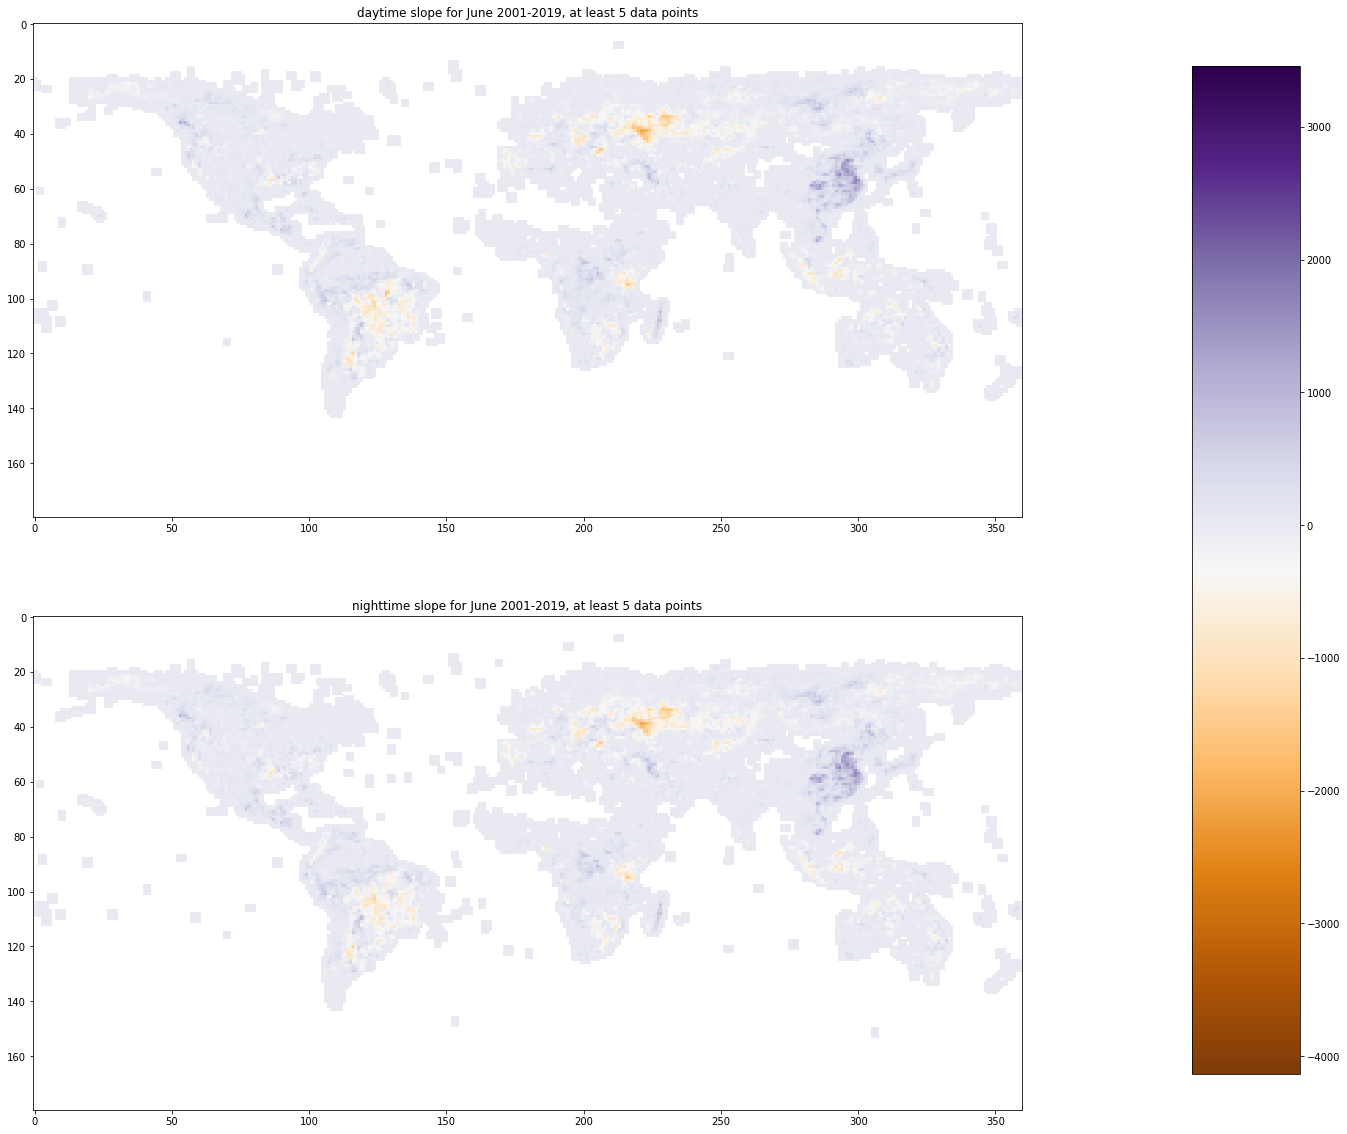

In [61]:
night_plot_im = np.ma.masked_equal(n_slope,0)
day_plot_im = np.ma.masked_equal(d_slope,0)

# aggregate?
night_resized = resize(night_plot_im, (int(night_plot_im.shape[0] / 4), int(night_plot_im.shape[1] / 4)), anti_aliasing=True)
night_resized = np.ma.masked_equal(night_resized,0)

day_resized = resize(day_plot_im, (int(day_plot_im.shape[0] / 4), int(day_plot_im.shape[1] / 4)), anti_aliasing=True)
day_resized = np.ma.masked_equal(day_resized,0)

fig, ax = plt.subplots(2,1, figsize=(30,20))
ax[0].imshow(day_resized, cmap='PuOr', vmin=absmin, vmax=absmax)
ax[0].set_title('daytime slope for June 2001-2019, at least {} data points'.format(n_obsv))
im=ax[1].imshow(night_resized, cmap='PuOr', vmin=absmin, vmax=absmax)
ax[1].set_title('nighttime slope for June 2001-2019, at least {} data points'.format(n_obsv))

fig.subplots_adjust(right=0.96)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()



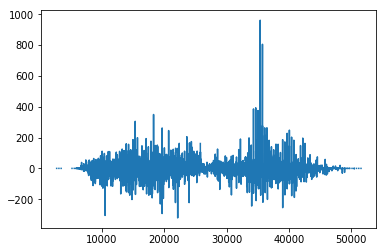

In [62]:
plt.plot(night_resized.ravel() - day_resized.ravel())

## do em all!

In [5]:
raster_folder = '../grid_0_25_degree_vars_2/'
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
out_folder = '../slopes_grid_0_25_degree_vars_2/slopes_month/'

# load spatial metadata for raster writing
with open('climate_grid_meta_0_25_wgs84.pickle', 'rb') as fp:
    meta = pickle.load(fp)

absmin=-80
absmax=50

for var in ['AFC_num', 'AFC_perc', 'FRP_max', 'FRP_mean', 'FRP_total']:
    for n_obsv in range(5,20):

        out_folder = '../slopes_grid_0_25_degree_vars_2/slopes_month/slopes_{}_month_numpts_{}/'.format(var, n_obsv)
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)

        for month in months:
            day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
            night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
            years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

            test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
            test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
            test_years = xr.DataArray(years, dims=['time'])

            d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
            n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)

            absmin = min(n_slope.min(), d_slope.min())
            absmax = min(n_slope.max(), d_slope.max())

    #         fig, ax = plt.subplots(2,1, figsize=(30,20))
    #         ax[0].imshow(d_slope, cmap='PuOr', vmin=absmin, vmax=absmax)
    #         ax[0].set_title('daytime slope for {} {}-{}'.format(month, min(years), max(years)))
    #         im=ax[1].imshow(n_slope, cmap='PuOr', vmin=absmin, vmax=absmax)
    #         ax[1].set_title('nighttime slope for {} {}-{}'.format(month, min(years), max(years)))

    #         fig.subplots_adjust(right=0.96)
    #         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #         fig.colorbar(im, cax=cbar_ax)

    #         plt.show()

    #         print('****************************************************************************************')
    #         print('****************************************************************************************')

            # save the slope as raster
            fname = 'modis_D_slope_{}_{}_{}_{}_numpts_{}.tif'.format(var, month, min(years), max(years), n_obsv)
            fpath = os.path.join(out_folder, fname)
            with rio.open(fpath, 'w', **meta) as dst:
                dst.write(np.expand_dims(d_slope,0).astype('float32'))

            fname = 'modis_N_slope_{}_{}_{}_{}_numpts_{}.tif'.format(var, month, min(years), max(years), n_obsv)
            fpath = os.path.join(out_folder, fname)
            with rio.open(fpath, 'w', **meta) as dst:
                dst.write(np.expand_dims(n_slope,0).astype('float32'))